Uncomment this section if imports below fail

In [38]:

# %pip install tensorflow
# %pip install keras
# %pip install matplotlib
# %pip install opencv-python opencv-python-headless
# !pip install -U scikit-learn


In [39]:
# Get data from kaggle 
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images
# ! unzip lung-and-colon-cancer-histopathological-images.zip

#Install Seaborn
# !pip3 install seaborn 

# !pip show tensorflow

In [40]:

import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout,InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from cv2 import imread,resize
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
import seaborn as sns

In [41]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

### Helper Functions

In [42]:
def get_model_path(classifications,name=None):
    if name is None:
        model_name = ''.join(classifications)
        model_name = model_name.replace('_','')+ '.keras'
    else:
        model_name = name + '.keras'

    i = 1
    while True:
        path = os.path.join('PastModels',model_name)
        if not os.path.exists(path):
            return os.path.join('PastModels',model_name)
        else:
            model_name = model_name.split('.')[0] + f'_{i}.keras'
            i+=1


# Data preparation
From the data set we have 5000 images from each class and to make sure that we are taking the right amount for our training and testing data we need to section this 5000x5 into evenly split training and testing data. To do this we are going to take 80% of the data for training and using the last 20% of the data for testing. This comes out to 5000*.8= 4000 images per classification for training and 5000*.2 images per classification for testing. This comes out to a total of 20,000 images to train on and 5000 images to test on. The following code will represent how that will be taken place

## Load in Data

In [43]:
# Get classifications from the strucutre of the directory
classifications = os.listdir('lung_colon_image_set')

batch_size = 32

# Load the data
data = tf.keras.utils.image_dataset_from_directory('lung_colon_image_set',class_names=classifications,shuffle=True,batch_size=batch_size,labels='inferred')

Found 25000 files belonging to 5 classes.


# Lets look at the data and see what it looks like 

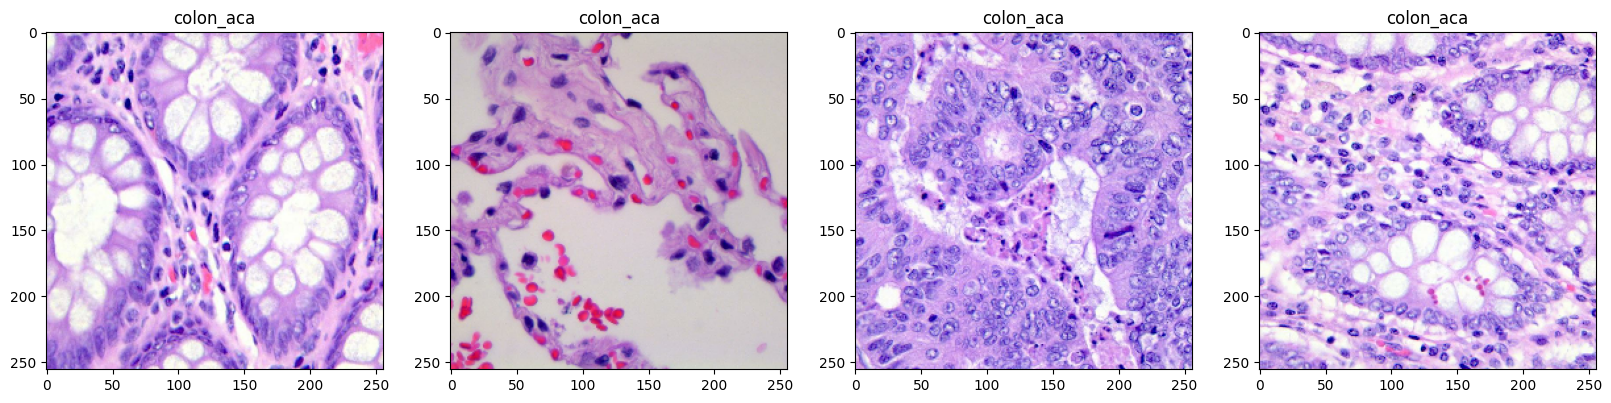

In [44]:
data_iterator = data.as_numpy_iterator()

batch = next(data_iterator)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(classifications[np.argmax(batch[1][idx], axis=-1)])
plt.show()

## Split the data

In [45]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [46]:
train_size

547

In [47]:
img = next(data_iterator)[0][0]
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [48]:

layers = [
    InputLayer(shape=img.shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(.03)),
    Dropout(.5),
    Dense(len(classifications), activation='softmax')]
    
model = Sequential(layers)


In [49]:

learning_rate = .0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [50]:
recompute = True
model_path = get_model_path(classifications,'FullModelAfterAdjustment')
if os.path.exists(model_path) and recompute == False:
    model = load_model(model_path)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,317 (11.62 MB)

 Trainable params: 3,044,357 (11.61 MB)

 Non-trainable params: 960 (3.75 KB)

# Training
The fun part about seeing if the model works well :smiley:

In [52]:


if os.path.exists(model_path) and recompute == False:
    print('Loaded past weights')
    hist = None
else:
    print('Fitting Model and saving weights')
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[early_stopping],batch_size=batch_size)
    model.save(model_path)
    hist_json_file = 'history.json' 
    json.dump(str(hist.history), open(hist_json_file, 'w'))

Fitting Model and saving weights
Epoch 1/20


547/547 ━━━━━━━━━━━━━━━━━━━━ 1531s 3s/step - accuracy: 0.7439 - loss: 15.8492 - val_accuracy: 0.8638 - val_loss: 9.9190
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1504s 3s/step - accuracy: 0.9049 - loss: 8.4575 - val_accuracy: 0.9151 - val_loss: 5.1302
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1514s 3s/step - accuracy: 0.9299 - loss: 4.4124 - val_accuracy: 0.9207 - val_loss: 2.8702
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1505s 3s/step - accuracy: 0.9445 - loss: 2.4696 - val_accuracy: 0.9385 - val_loss: 1.7689
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1488s 3s/step - accuracy: 0.9486 - loss: 1.5822 - val_accuracy: 0.9597 - val_loss: 1.1887
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1555s 3s/step - accuracy: 0.9624 - loss: 1.0987 - val_accuracy: 0.9341 - val_loss: 0.9399
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1551s 3s/step - accuracy: 0.9619 - loss: 0.8441 - val_accuracy: 0.9593 - val_loss: 0.7323
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1532s 3s/step - accuracy: 0.9678 - loss: 0.6970 - val_accura

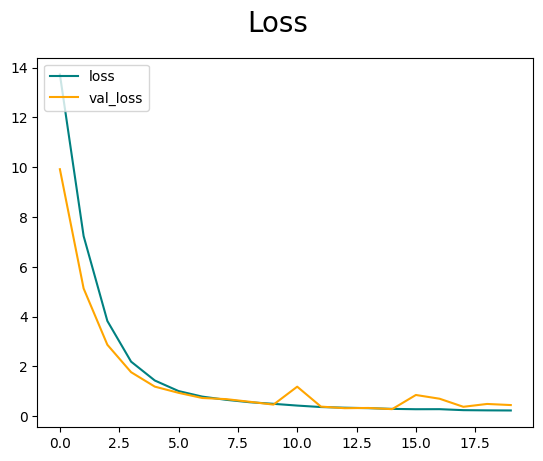

In [53]:
if hist:
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print('No history to plot loss')

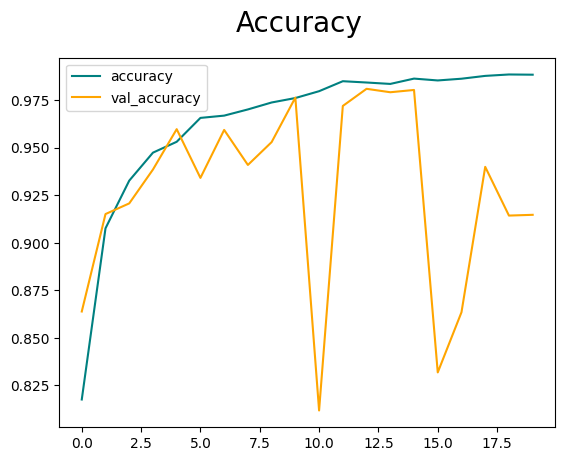

In [54]:
if hist:
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print('No history to plot accuracy')

Precision: 0.9994892477989197
Recall: 0.9974516034126282
Accuracy: 0.9102563858032227


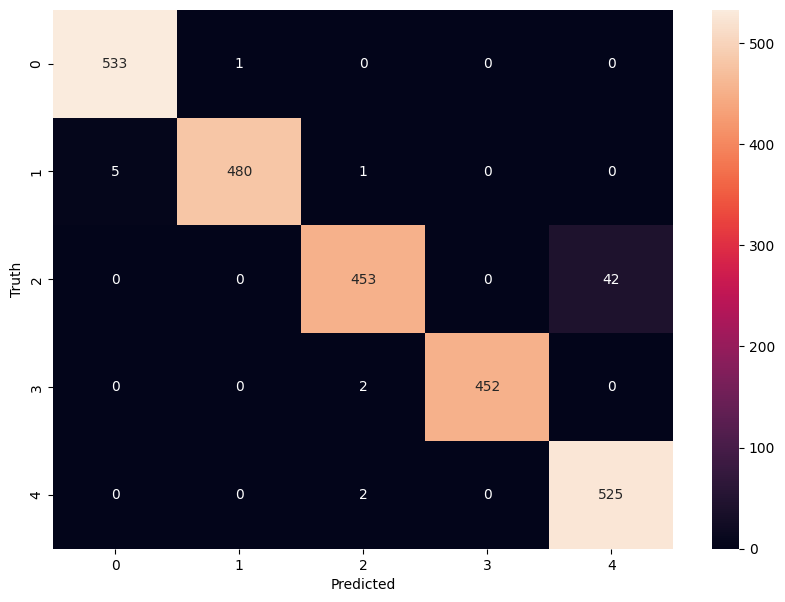

In [55]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
y_true = []
y_pred = []

for imgs, ys in test:
    # Make a prediction for the entire batch
    yhats = model.predict(imgs,verbose=0)
    
    # Convert the predictions to class indices
    yhats = np.argmax(yhats, axis=-1)

    y_true.extend([classifications[x] for x in ys.numpy().tolist()])
    y_pred.extend([classifications[x] for x in yhats.tolist()])


    
    # Update the metrics
    pre.update_state(ys, yhats)
    re.update_state(ys, yhats)
    acc.update_state(ys, yhats)

cm = confusion_matrix(y_true, y_pred)


# Print the final results
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [56]:


actual = 'lung_aca'
for i in range(1,5001):
    string = f'lungaca{i}.jpeg'
    img = imread(os.path.join('lung_colon_image_set',actual,string))
    img = resize(img, (256,256))
    img = np.expand_dims(img, axis=0)
    yhat = model.predict(img,verbose=0)
    max_idx = np.argmax(yhat)
    if classifications[max_idx] == actual:
        break
print(i)
print(f'predicted: {classifications[max_idx]} actual: {actual}')

182
predicted: lung_aca actual: lung_aca
